## Imports

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import gc
import sys
import sklearn
import scipy
import xlearn as xl
from itertools import product

from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, log_loss
from scipy.sparse import csr_matrix

pd.set_option("display.float_format", lambda x: "%.3f" % x)

## Functions

In [2]:
def load_data(data_path):
    columns_to_use = [
        "date_time",
        "zone_id",
        "banner_id",
        "campaign_clicks",
        "os_id",
        "country_id",
        "impressions",
        "clicks",
        "oaid_hash",
    ]
    categorical_columns = [
        "zone_id",
        "banner_id",
        "os_id",
        "country_id",
        "impressions",
        "clicks",
    ]
    data = pd.read_csv(data_path, usecols=columns_to_use, parse_dates=["date_time"])
    data[categorical_columns].astype("category")
    return data

In [3]:
def group_categories(data, column_names, threshold):
    for column in column_names:
        new_value = data[column].max() + 1000
        categories_to_group = data[column].value_counts(normalize=True) < threshold
        categories_to_group = categories_to_group[categories_to_group].index
        data.loc[data[column].isin(categories_to_group), column] = new_value
    return data

In [4]:
def feature_engineering(data, interactions=None):
    # Удалим столбец impressions
    data.drop(["impressions"], axis=1, inplace=True)

    # Временные признаки
    data["hour"] = data.date_time.dt.hour
    data["weekday"] = data.date_time.dt.weekday

    # Группировка редких категорий в banner_id, zone_id, oaid_hash
    data = group_categories(data, ["banner_id", "zone_id"], 0.001)
    oaid_hash_vc = data.oaid_hash.value_counts()
    oaid_hash_to_change = oaid_hash_vc[oaid_hash_vc <= 2].index
    data.loc[data.oaid_hash.isin(oaid_hash_to_change), "oaid_hash"] = -100

    # Нормировка campaign_clicks
    data["campaign_clicks"] = np.log1p(data.campaign_clicks + 1)

    return data

In [5]:
def train_test_split(data):
    ts = pd.Timestamp("2021-10-02 00:00:00")
    data.sort_values(by="date_time", inplace=True)
    train_mask, test_mask = data.date_time < ts, data.date_time >= ts
    X_train, X_test = data[train_mask].copy(), data[test_mask].copy()
    y_train, y_test = X_train.clicks.to_numpy(), X_test.clicks.to_numpy()
    return X_train, y_train, X_test, y_test

## Data analysis

**Этап 1:** загрузим датасет

In [6]:
data_path = "data.csv"
data = load_data(data_path)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,1,1


**Этап 2:** анализ данных

Так как данные у нас не поменялись, за исключением нового столбца - `oaid_hash`, проанализируем только его

In [7]:
def oaid_hash_analysis(data):
    vc = data.oaid_hash.value_counts()
    vc.reset_index(inplace=True, drop=True)
    vc.plot(figsize=(8, 4), xlabel="oaid_hash", ylabel="value counts", grid=True)
    plt.show()

    print(f"Уникальных категорий в столбце: {len(data.oaid_hash.unique())}\n")
    print(
        f"Доля пользователей, для которых всего 1 наблюдение в датасете: {(vc == 1).sum() / len(vc):.3f}\n"
    )
    print("Доля пользователей, для которых всего k наблюдений в датасете:\n")
    print(vc.value_counts(normalize=True)[:10])

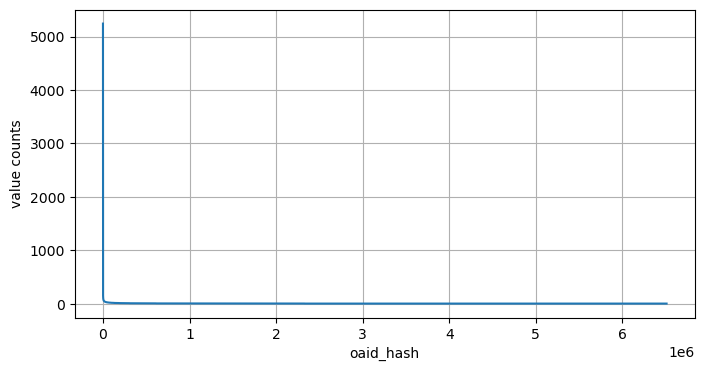

Уникальных категорий в столбце: 6510316

Доля пользователей, для которых всего 1 наблюдение в датасете: 0.642

Доля пользователей, для которых всего k наблюдений в датасете:

1    0.642
2    0.161
3    0.066
4    0.036
5    0.022
6    0.015
7    0.010
8    0.008
9    0.006
10   0.005
Name: oaid_hash, dtype: float64


/tmp/ipykernel_11741/2664417664.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(vc.value_counts(normalize=True)[:10])


In [8]:
oaid_hash_analysis(data)

Видно, что распределение сильно ассиметричное, очень много пользователей, для которых всего лишь одно или два наблюдения, что будет вносить шум в модель, поэтому объединим таких пользователей в отдельную категорию (`k = 1`, `k = 2`)

## Feature engineering

***Фичи, которые будем использовать:***
1. banner_id
2. zone_id
3. hour
4. weekday
5. country_id
6. oaid_hash
7. os_id
8. log campaign_clicks

In [9]:
data = feature_engineering(data)

## Prepare data for training with xlearn

Для обучения `field aware factorization machine` будем использовать пакет `xlearn`. Для того, чтобы что-то обучалось, необходимо привести данные к определенному формату: датасеты - трейн, валидация и тест - сохраняются в файлики `.txt`. Сначала сохраним данные в разреженные матрицы, чтобы предобработка данных прошла чуть быстрее.

В этот раз сделаем обычную  валидацию. `One-Hot` энкодер фиттится только на трейне, чтобы не было утечки информации в тест. Если энкодер встретит в тесте что-то непонятное для него, он пропустит такое наблюдение.

Функции не выношу наверх, чтобы было понятно, что происходит.

In [11]:
CATEGORICAL_FEATURES = [
    "banner_id",
    "zone_id",
    "hour",
    "weekday",
    "country_id",
    "oaid_hash",
    "os_id",
]
NUMERICAL_FEATURES = ["campaign_clicks"]
ALL_FEATURES = CATEGORICAL_FEATURES + NUMERICAL_FEATURES

In [12]:
def create_sparse_matrix(data, encoder):
    sparse_cat = encoder.transform(data[CATEGORICAL_FEATURES])
    sparse_num = csr_matrix(data[NUMERICAL_FEATURES])

    fields = np.arange(sparse_cat.shape[1] + len(NUMERICAL_FEATURES))
    cur_code = 0
    h = np.hstack(([0], np.cumsum(encoder._n_features_outs)))
    for i in range(1, len(h)):
        fields[h[i - 1] : h[i]] = cur_code
        cur_code += 1

    for i in range(len(NUMERICAL_FEATURES), 0, -1):
        fields[-i] = cur_code
        cur_code += 1

    csr = scipy.sparse.hstack((sparse_cat, sparse_num))
    return csr, fields

In [13]:
def prepare_data_for_libffm(data):
    print("Preparing the data...\n")
    # Делим датасет на трейн и тест
    X_train, y_train, X_test, y_test = train_test_split(data)

    # Зафиттим энкодер только на трейне и запомним его, чтобы использовать на тесте
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    encoder.fit(X_train[CATEGORICAL_FEATURES])

    # Делим трейн на трейн и валидацию
    train_ids = np.arange(len(X_train))
    train_ids, val_ids = sklearn.model_selection.train_test_split(
        train_ids, test_size=0.2, stratify=y_train
    )
    X_val, y_val = X_train.iloc[val_ids], y_train[val_ids]
    X_train, y_train = X_train.iloc[train_ids], y_train[train_ids]

    assert (
        X_train.shape[0] == y_train.shape[0]
    ), "The dimensions of the dataset and labels do not match"
    assert (
        X_val.shape[0] == y_val.shape[0]
    ), "The dimensions of the dataset and labels do not match"

    print("Number of observations in datasets:")
    print(f"train:      {X_train.shape[0]}")
    print(f"validation: {X_val.shape[0]}")
    print(f"test:       {X_test.shape[0]}\n")

    # Создаем разреженные матрицы и поля
    X_train_sparse, train_fields = create_sparse_matrix(X_train, encoder)
    X_val_sparse, val_fields = create_sparse_matrix(X_val, encoder)
    X_test_sparse, test_fields = create_sparse_matrix(X_test, encoder)

    assert X_train_sparse.shape[1] == len(
        train_fields
    ), "Each feature must have a field defined!"
    assert X_val_sparse.shape[1] == len(
        val_fields
    ), "Each feature must have a field defined!"
    assert X_test_sparse.shape[1] == len(
        test_fields
    ), "Each feature must have a field defined!"

    num_features = len(NUMERICAL_FEATURES) + len(CATEGORICAL_FEATURES)
    assert (
        len(X_train_sparse.nonzero()[0]) == len(X_train) * num_features
    ), "Something is wrong..."
    assert (
        len(X_val_sparse.nonzero()[0]) == len(X_val) * num_features
    ), "Something is wrong..."
    assert X_train_sparse.shape[1] == X_val_sparse.shape[1] == X_test_sparse.shape[1]

    print(f"Total number of features: {X_train_sparse.shape[1]}")
    matrices = [X_train_sparse, X_val_sparse, X_test_sparse]
    fields = [train_fields, val_fields, test_fields]
    ys = [y_train, y_val, y_test]
    
    print("Done!")
    return matrices, fields, ys

In [3]:
def convert_to_libffm(X, y, fields, out_path):
    """
    Function which helps to get file with rows like this:
     <label> <field1>:<feature1>:<value1> <field2>:<feature2>:<value2>
    """
    
    values = X.data
    rows, cols = X.nonzero()
    with open(out_path, "w") as file:
        cur_obs = rows[0]
        file.write(f"{y[cur_obs]}")
        for obs, feature, value in zip(rows, cols, values):
            if obs == cur_obs:
                file.write(f" {fields[feature]}:{feature}:{value}")
            else:
                cur_obs = obs
                file.write("\n")
                file.write(f"{y[cur_obs]}")
                file.write(f" {fields[feature]}:{feature}:{value}")

 Приступаем к делу: нам необходимо получить фичи, поле для каждой фичи и лейблы для каждого наблюдения

In [14]:
matrices, fields, ys = prepare_data_for_libffm(data)

Preparing the data...

Number of observations in datasets:
train:      10953995
validation: 2738499
test:       2128978

Total number of features: 1170867
Done!


Сохраняем наши данные в файлы, которые далее будем использовать при обучении и тестировании

In [17]:
out_names = ["train.txt", "val.txt", "test.txt"]

In [18]:
for name, X, field, y in zip(out_names, matrices, fields, ys):
    print(f"Converting to {name}...")
    convert_to_libffm(X, y, field, name)
    print(f"Convertion to {name} is completed!\n")

Converting to train.txt...
Convertion to train.txt is completed!

Converting to val.txt...
Convertion to val.txt is completed!

Converting to test.txt...
Convertion to test.txt is completed!



## Training and testing FFM

Будем обучать модельки и перебирать гиперпараметры: коэффициент регуляризации и размерность для FFM. К сожалению, почему-то при переборе всех гиперпараметров в едином цикле ядро падает из-за нехватки памяти, даже при условии использования сборщика мусора. Поэтому придется руками обучать модели для каждой комбинации гиперпараметров :(

In [ ]:
params = {"lambda": [0.00001, 0.0001, 0.001, 0.01, 0.1], "dim": [4, 8, 12, 16]}

In [2]:
def train_model(param, model_prefix):
    print(f"Training with parameters: {model_prefix}\n")
    ffm_model = xl.create_ffm()
    ffm_model.setTrain("train.txt")
    ffm_model.setValidate("val.txt")
    ffm_model.fit(param, f"models/{model_prefix}.out")
    return f"models/{model_prefix}.out"

In [12]:
def test_model(path_to_model, model_prefix, y_test):
    print(f"Testing {model_prefix}\n")
    ffm_model = xl.create_ffm()
    ffm_model.setSigmoid()
    ffm_model.setTest("test.txt")
    pred_path = f"predictions/{model_prefix}.out"
    ffm_model.predict(path_to_model, pred_path)

    pred = np.genfromtxt(pred_path, dtype=float)
    res = {"log_loss": log_loss(y_test, pred), "roc_auc": roc_auc_score(y_test, pred)}
    return res

### Lots of output...

In [14]:
reg_lambda = 0.00001
dim = 4

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=1e-05, dim=4

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading

'models/lambda=1e-05, dim=4.out'

In [4]:
reg_lambda = 0.00001
dim = 8

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=1e-05, dim=8

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading

'models/lambda=1e-05, dim=8.out'

In [5]:
reg_lambda = 0.00001
dim = 12

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=1e-05, dim=12

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for readin

'models/lambda=1e-05, dim=12.out'

In [6]:
reg_lambda = 0.00001
dim = 16

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=1e-05, dim=16

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for readin

'models/lambda=1e-05, dim=16.out'

In [10]:
reg_lambda = 0.0001
dim = 4

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.0001, dim=4

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for readin

'models/lambda=0.0001, dim=4.out'

In [11]:
reg_lambda = 0.0001
dim = 8

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.0001, dim=8

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for readin

'models/lambda=0.0001, dim=8.out'

In [5]:
reg_lambda = 0.0001
dim = 12

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.0001, dim=12

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for readi

'models/lambda=0.0001, dim=12.out'

[------------] Total time cost: 57.61 (sec)


In [6]:
reg_lambda = 0.0001
dim = 16

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.0001, dim=16

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for readi

'models/lambda=0.0001, dim=16.out'

In [4]:
reg_lambda = 0.001
dim = 4

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.001, dim=4

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading

'models/lambda=0.001, dim=4.out'

In [5]:
reg_lambda = 0.001
dim = 8

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.001, dim=8

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading

'models/lambda=0.001, dim=8.out'

In [6]:
reg_lambda = 0.001
dim = 12

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.001, dim=12

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for readin

'models/lambda=0.001, dim=12.out'

In [4]:
reg_lambda = 0.001
dim = 16

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.001, dim=16

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for readin

'models/lambda=0.001, dim=16.out'

In [5]:
reg_lambda = 0.01
dim = 4

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.01, dim=4

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading 

'models/lambda=0.01, dim=4.out'

In [6]:
reg_lambda = 0.01
dim = 8

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.01, dim=8

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading 

'models/lambda=0.01, dim=8.out'

In [7]:
reg_lambda = 0.01
dim = 12

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.01, dim=12

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading

'models/lambda=0.01, dim=12.out'

In [8]:
reg_lambda = 0.01
dim = 16

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.01, dim=16

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading

'models/lambda=0.01, dim=16.out'

In [4]:
reg_lambda = 0.1
dim = 4

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.1, dim=4

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading p

'models/lambda=0.1, dim=4.out'

In [5]:
reg_lambda = 0.1
dim = 8

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.1, dim=8

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading p

'models/lambda=0.1, dim=8.out'

In [6]:
reg_lambda = 0.1
dim = 12

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.1, dim=12

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading 

'models/lambda=0.1, dim=12.out'

In [7]:
reg_lambda = 0.1
dim = 16

model_prefix = f"lambda={reg_lambda}, dim={dim}"
param = {"task": "binary", "lambda": reg_lambda, "k": dim}
train_model(param, model_prefix=f"lambda={reg_lambda}, dim={dim}")

Training with parameters: lambda=0.1, dim=16

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading 

'models/lambda=0.1, dim=16.out'

### Let's test our models!

In [13]:
def get_result(params):
    result = {}
    for reg_coef, dim in product(params["lambda"], params["dim"]):
        prefix = f"lambda={reg_coef}, dim={dim}"
        name = f"models/{prefix}.out"
        prefix = f"lambda={reg_coef}, dim={dim}"
        result[f"({reg_coef}, {dim})"] = test_model(name, prefix, y_test)

    with open("result.pkl", "wb") as f:
        pickle.dump(result, f)

    return (
        pd.DataFrame.from_dict(result)
        .transpose()
        .sort_values(by=["roc_auc"], ascending=False)
    )

In [14]:
params = {"lambda": [0.00001, 0.0001, 0.001, 0.01, 0.1], "dim": [4, 8, 12, 16]}

In [15]:
result = get_result(params)

Testing lambda=1e-05, dim=4

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for prediction task.
[ ACTION     ] Load model ...
[------------] Load model from models/lambda=1e-05, dim=4.out
[------------] Loss function: cross-entropy
[------------] Score function: ffm
[------------] Number of Feature: 1170867
[------------] Number of K: 4
[------------] Number of field: 8
[------------] Time cost for loading model: 0.37 (sec)
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (test.txt.bin) found

In [16]:
result

,log_loss,roc_auc
"(0.0001, 4)",0.128,0.804
"(1e-05, 4)",0.128,0.803
"(0.0001, 8)",0.129,0.800
"(0.0001, 16)",0.129,0.799
"(1e-05, 8)",0.131,0.799
"(0.0001, 12)",0.129,0.798
"(1e-05, 12)",0.130,0.798
"(1e-05, 16)",0.131,0.795
"(0.001, 16)",0.131,0.792
"(0.001, 8)",0.131,0.792


Итак, получили лучший результат как и по `log_loss`, так и по `roc_auc` со следующими параметрами:
1. Коэффициент регуляризации - 0.0001
2. Размерность векторов - 4
   

In [18]:
print(f"Training best model: lambda=0.0001, dim=4\n")
ffm_model = xl.create_ffm()
ffm_model.setTrain("train.txt")
param = {"task": "binary", "lambda": 0.0001, "k": 4}
ffm_model.fit(param, f"models/best.out")

Training best model: lambda=0.0001, dim=4

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[ WARNING    ] Validation file not found, xLearn has already disable early-stopping.
[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 1170867
[------------] Number of Field: 8
[------------] Time cost for reading problem: 7.53 (sec)
[ ACTION     ] Initialize model ...
[------------] Model size: 294.

In [19]:
res = test_model("models/best.out", "best", y_test)

Testing best

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for prediction task.
[ ACTION     ] Load model ...
[------------] Load model from models/best.out
[------------] Loss function: cross-entropy
[------------] Score function: ffm
[------------] Number of Feature: 1170867
[------------] Number of K: 4
[------------] Number of field: 8
[------------] Time cost for loading model: 0.21 (sec)
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (test.txt.bin) found. Skip converting text to bina

In [22]:
compare = {
    "ffm": res,
    "linear model": {"log_loss": 0.1342, "roc_auc": 0.7843},
    "baseline": {"log_loss": 0.1549, "roc_auc": 0.5000},
}

In [23]:
pd.DataFrame.from_dict(compare).transpose().sort_values(by=["roc_auc"], ascending=False)

,log_loss,roc_auc
ffm,0.128,0.802
linear model,0.134,0.784
baseline,0.155,0.500


Итак, нам удалось обучить факторизационную машину, которая более точно делает предсказания, чем линейная модель с предыдущего домашнего задания.